# YOUR PROJECT TITLE

> **Note the following:** 
> 1. This is *not* meant to be an example of an actual **data analysis project**, just an example of how to structure such a project.
> 1. Remember the general advice on structuring and commenting your code from [lecture 5](https://numeconcopenhagen.netlify.com/lectures/Workflow_and_debugging).
> 1. Remember this [guide](https://www.markdownguide.org/basic-syntax/) on markdown and (a bit of) latex.
> 1. Turn on automatic numbering by clicking on the small icon on top of the table of contents in the left sidebar.
> 1. The `dataproject.py` file includes a function which will be used multiple times in this notebook.

Imports and set magics:

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
from matplotlib_venn import venn2 
import numpy as np
# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# local modules
import dataproject

# import pydst
import pydst
dst = pydst.Dst(lang='en')

# Read and clean data

## Employment data

**Read the employment data** in ``RAS200.xlsx`` and **clean it** removing and renaming columns:

In [4]:
educ_vars = dst.get_variables(table_id='HFUDD10')
educ_vars

#a. Download data
educ = dst.get_data(table_id = 'HFUDD10', variables={'Tid':['*'],'HERKOMST':['*'], 'HFUDD':['TOT','H30', 'H40','H50','H60','H70'], 'KØN':['*']})
educ.head(10)

# b. drop columns
drop_these = ['BOPOMR','ALDER']
educ.drop(drop_these, axis=1, inplace=True)
educ.head(10)


# c. rename columns
educ.rename(columns = {'HERKOMST':'Ancestry', 'KØN':'Gender', 'TID':'Year', 'HFUDD':'HCEDUC', 'INDHOLD':'Units'}, inplace=True)

educ['HCEDUC']=educ.HCEDUC.astype(str).str[4:]


# d. Set index to year
educ.set_index('Year')


,Ancestry,HCEDUC,Gender,Units
Year,,,,
2006,Descendant,Vocational Education and Training (VET),Women,1938
2006,Descendant,Vocational Education and Training (VET),Men,1756
2006,Descendant,Vocational Education and Training (VET),Total,3694
2006,Descendant,Short cycle higher education,Women,314
2006,Descendant,Short cycle higher education,Men,370
...,...,...,...,...
2019,Total,Masters programmes,Men,196119
2019,Total,Masters programmes,Total,400602
2019,Total,l,Women,2001093


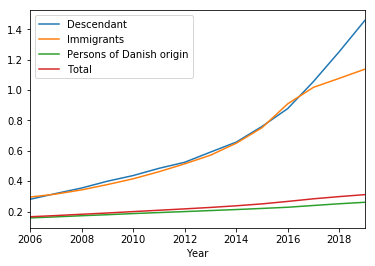

In [4]:
educ1 = educ.copy()

for val in ['Men', 'Women']: 
    I = educ1.Gender.str.contains(val)
    educ1 = educ1.loc[I == False] # keep everything else

# a. split
educ_grouped = educ.groupby(['Ancestry', 'Gender'])
educ_grouped_first = educ_grouped.Units.first()
educ_grouped_first.name = 'first'

# b. apply
educ1.set_index(['Ancestry','Gender','Year'],inplace=True)
educ1 = educ1.join(educ_grouped_first,how='left',on=['Ancestry','Gender'])
educ1.reset_index(inplace=True)

# c. combine
educ1['indexed'] = educ1['Units']/educ1['first']

# d. plot
def plot(df):
    df_indexed = df.set_index('Year')
    I = df_indexed.HCEDUC == 'Masters programmes'
    df_indexed[I].groupby(['Ancestry'])['indexed'].plot(legend=True);
    
plot(educ1)




In [16]:
#Download population data from dst
pop = dst.get_data(table_id = 'FOLK1C', variables={'Tid':['*'], 'HERKOMST':['*'], 'KØN':['*']})

#Drop columns
drop_these = drop_these = ['OMRÅDE','ALDER', 'IELAND']
pop.drop(drop_these, axis=1, inplace=True)

#Rename columns
pop.rename(columns = {'HERKOMST':'Ancestry', 'KØN':'Gender', 'TID':'Year','INDHOLD':'Pop'}, inplace=True)

for val in ['Q2','Q3','Q4']: 
    I = pop.Year.str.contains(val)
    pop.drop(pop[I].index, inplace=True)

pop.Year.astype(str)
pop['Year']= pop.Year.astype(str).str[:4]

#Merge population data with education data (merge pop with educ)
pop.Year = pop.Year.astype(int)
merged = pd.merge(educ, pop, how='inner',on=['Year','Ancestry','Gender'])
merged.head()


,Year,Ancestry,HCEDUC,Gender,Units,Pop
0,2008,Descendant,Vocational Education and Training (VET),Women,2273,58393
1,2008,Descendant,Short cycle higher education,Women,395,58393
2,2008,Descendant,Vocational bachelors educations,Women,1048,58393
3,2008,Descendant,Bachelors programmes,Women,397,58393
4,2008,Descendant,Masters programmes,Women,610,58393


In [17]:
#Make a new column with number of people with education as a share of number of people in poplation 
merged['Share'] = merged['Units']/merged['Pop'] * 100
merged.head()

,Year,Ancestry,HCEDUC,Gender,Units,Pop,Share
0,2008,Descendant,Vocational Education and Training (VET),Women,2273,58393,3.892590
1,2008,Descendant,Short cycle higher education,Women,395,58393,0.676451
2,2008,Descendant,Vocational bachelors educations,Women,1048,58393,1.794736
3,2008,Descendant,Bachelors programmes,Women,397,58393,0.679876
4,2008,Descendant,Masters programmes,Women,610,58393,1.044646


In [18]:
#Only select the number of people with completed master programmes
for val in ['Masters programmes']: 
    I = merged.HCEDUC.str.contains(val)
    merged = merged.loc[I == True] # keep everything else
merged.head()

,Year,Ancestry,HCEDUC,Gender,Units,Pop,Share
4,2008,Descendant,Masters programmes,Women,610,58393,1.044646
10,2008,Descendant,Masters programmes,Men,701,60904,1.150992
16,2008,Descendant,Masters programmes,Total,1311,119297,1.098938
22,2008,Immigrants,Masters programmes,Women,10899,192713,5.655560
28,2008,Immigrants,Masters programmes,Men,12721,185952,6.841013


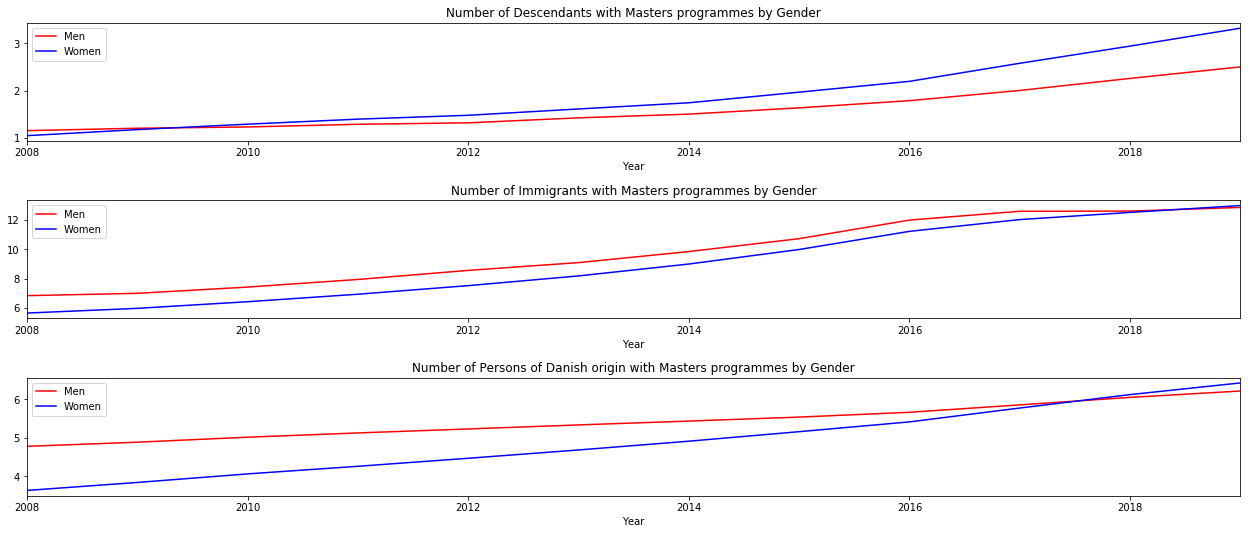

In [20]:
# Make a figure with 3 subplots showing the share of people with master programmes by ancestry and gender
plt.figure(figsize=(20,10))

#Figure 1: Plot with share of descendants with master programmes by gender
merged1 = merged.copy()
I = merged1.Ancestry == 'Descendant'
x = merged[I]

ax = plt.subplot(311)

J = x.Gender == 'Men'
y1 = x[J]
y1.rename(columns = {'Share':'Men'}, inplace=True)
y1.plot(kind='line', x = 'Year', y='Men', color='red', ax=ax)

K = x.Gender == 'Women'
y2 = x[K]
y2.rename(columns = {'Share':'Women'}, inplace=True)
y2.plot(kind='line', x = 'Year', y='Women', color='blue', ax=ax)
ax.set_title('Number of Descendants with Masters programmes by Gender')

#Figure 2: Plot with share of immigrants with master programmes by gender
merged2 = merged.copy()
I = merged2.Ancestry == 'Immigrants'
x = merged2[I]

ax1 = plt.subplot(312)

J = x.Gender == 'Men'
y1 = x[J]
y1.rename(columns = {'Share':'Men'}, inplace=True)
y1.plot(kind='line', x = 'Year', y='Men', color='red', label='Men', ax=ax1)

K = x.Gender == 'Women'
y2 = x[K]
y2.rename(columns = {'Share':'Women'}, inplace=True)
y2.plot(kind='line', x = 'Year', y='Women', color='blue', ax=ax1, label='Women')
ax1.set_title('Number of Immigrants with Masters programmes by Gender')

#Figure 3: Plot with share of persons of danish origin with master programmes by gender
merged3 = merged.copy()
I = merged3.Ancestry == 'Persons of Danish origin'
x = merged3[I]

ax2 = plt.subplot(313)

J = x.Gender == 'Men'
y1 = x[J]
y1.rename(columns = {'Share':'Men'}, inplace=True)
y1.plot(kind='line', x = 'Year', y='Men', color='red', ax=ax2)

K = x.Gender == 'Women'
y2 = x[K]
y2.rename(columns = {'Share':'Women'}, inplace=True)
y2.plot(kind='line', x = 'Year', y='Women', color='blue', ax=ax2)
ax2.set_title('Number of Persons of Danish origin with Masters programmes by Gender')


plt.tight_layout(pad=10,h_pad=20,w_pad=20)

## Income data

**Read the income data** in ``INDKP101.xlsx`` and **clean it**:

In [ ]:
# a. load
#inc = pd.read_excel('INDKP101.xlsx', skiprows=2)

# b. drop and rename columns
#inc.drop([f'Unnamed: {i}' for i in range(3)], axis=1, inplace=True)
#inc.rename(columns = {'Unnamed: 3':'municipality'}, inplace=True)

# c. drop rows with missing
#inc.dropna(inplace=True)

# d. remove non-municipalities
#inc = dataproject.only_keep_municipalities(inc)

# e. convert to long
#inc.rename(columns = {str(i):f'income{i}' for i in range(1986,2018)}, inplace=True)
#inc_long = pd.wide_to_long(inc, stubnames='income', i='municipality', j='year').reset_index()

# f. show
#inc_long.head(5)

> **Note:** The function ``dataproject.only_keep_municipalities()`` is used on both the employment and the income datasets.

## Explore data set

In order to be able to **explore the raw data**, we here provide an **interactive plot** to show, respectively, the employment and income level in each municipality

The **static plot** is:

In [ ]:
def plot_empl_inc(empl,inc,dataset,municipality): 
    
    if dataset == 'Employment':
        df = empl
        y = 'employment'
    else:
        df = inc
        y = 'income'
    
    I = df['municipality'] == municipality
    ax = df.loc[I,:].plot(x='year', y=y, style='-o')

The **interactive plot** is:

In [ ]:
widgets.interact(plot_empl_inc, 
    
    empl = widgets.fixed(empl_long),
    inc = widgets.fixed(inc_long),
    dataset = widgets.Dropdown(description='Dataset', 
                               options=['Employment','Income']),
    municipality = widgets.Dropdown(description='Municipality', 
                                    options=empl_long.municipality.unique())
                 
); 

ADD SOMETHING HERE IF THE READER SHOULD KNOW THAT E.G. SOME MUNICIPALITY IS SPECIAL.

# Merge data sets

We now create a data set with **municpalities which are in both of our data sets**. We can illustrate this **merge** as:

In [ ]:
plt.figure(figsize=(15,7))
v = venn2(subsets = (4, 4, 10), set_labels = ('inc', 'empl'))
v.get_label_by_id('100').set_text('dropped')
v.get_label_by_id('010').set_text('dropped' )
v.get_label_by_id('110').set_text('included')
plt.show()

In [ ]:
merged = pd.merge(empl_long, inc_long, how='inner',on=['municipality','year'])

print(f'Number of municipalities = {len(merged.municipality.unique())}')
print(f'Number of years          = {len(merged.year.unique())}')

# Analysis

To get a quick overview of the data, we show some **summary statistics by year**:

In [ ]:
merged.groupby('year').agg(['mean','std']).round(2)

ADD FURTHER ANALYSIS. EXPLAIN THE CODE BRIEFLY AND SUMMARIZE THE RESULTS.

# Conclusion

ADD CONCISE CONLUSION.